# Introduction
**FCSE Team 9 Mini Project**

`Group Members`

**Chua Tze Wu<br> Chin Linn Sheng<br>**

The [dataset](https://www.kaggle.com/datasets/nelgiriyewithana/emotions) we used was taken from Kaggle.


Included in the dataset are 2 columns:
- text: `A string feature representing the content of the Twitter message`
- label: `A classification label indicating the primary emotion, with values ranging from 0 to 5`

## Problem Statement

To accurately predict and classify the sentiment of tweets into the six categories: **`sadness`**, **`joy`**, **`love`**, **`anger`**, **`fear`** or **`surprise`** using different models.

## Importing Library

In [1]:
##Importing Library
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
import spacy
import string
import random

from wordcloud import WordCloud

from collections import Counter

from spellchecker import SpellChecker

import plotly.express as plotex

import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB



In [2]:
pd.options.mode.chained_assignment = None
data = pd.read_csv('text.csv')
data.drop(columns='Unnamed: 0', inplace=True)
data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


## PREPROCESSING DATA

## Feature engineering
Adding column of `label_string` for more legibility

In [3]:
#map labels to easy-understanding words
label_map={
    0:'sadness',
    1:'joy',
    2:'love',
    3:'anger',
    4:'fear',
    5:'surprise'
}
data['label_string']=data['label'].map(label_map)
data.head()

,text,label,label_string
0,i just feel really helpless and heavy hearted,4,fear
1,ive enjoyed being able to slouch about relax a...,0,sadness
2,i gave up my internship with the dmrg and am f...,4,fear
3,i dont know i feel so lost,0,sadness
4,i am a kindergarten teacher and i am thoroughl...,4,fear


In [4]:
data.describe

<bound method NDFrame.describe of                                                      text  label label_string
0           i just feel really helpless and heavy hearted      4         fear
1       ive enjoyed being able to slouch about relax a...      0      sadness
2       i gave up my internship with the dmrg and am f...      4         fear
3                              i dont know i feel so lost      0      sadness
4       i am a kindergarten teacher and i am thoroughl...      4         fear
...                                                   ...    ...          ...
416804  i feel like telling these horny devils to find...      2         love
416805  i began to realize that when i was feeling agi...      3        anger
416806  i feel very curious be why previous early dawn...      5     surprise
416807  i feel that becuase of the tyranical nature of...      3        anger
416808  i think that after i had spent some time inves...      5     surprise

[416809 rows x 3 columns]>

### REMOVING DUPLICATES

In [5]:
duplicate_list = data[data.duplicated('text')]['text'].to_list()
print(f"Total duplicates in the data:{len(duplicate_list)}")

Total duplicates in the data:22987


In [6]:
## Showing example of duplicate text
duplicate_list_s = random.sample(duplicate_list,1)
data[data["text"]==duplicate_list_s[0]]

,text,label,label_string
99122,i feel like i repeat myself by saying it it tr...,1,joy
166421,i feel like i repeat myself by saying it it tr...,5,surprise


In [7]:
data.drop_duplicates('text', inplace = True)
print(f"Shape of the data after removing duplicates:{data.shape}")

Shape of the data after removing duplicates:(393822, 3)


### DELETING STOPWORDS
Stopwords are commonly occuring words in a language like 'the', 'a' and so on. They can be removed from the text most of the times, as they don't provide valuable information for downstream analysis. In cases like Part of Speech tagging, we should not remove them as provide very valuable information about the POS.

In [8]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply((lambda text: remove_stopwords(text)))
data.info

<bound method DataFrame.info of                                                      text  label label_string
0                      feel really helpless heavy hearted      4         fear
1       ive enjoyed able slouch relax unwind frankly n...      0      sadness
2                 gave internship dmrg feeling distraught      4         fear
3                                     dont know feel lost      0      sadness
4       kindergarten teacher thoroughly weary job take...      4         fear
...                                                   ...    ...          ...
416803  cry feel sense loss patients die helped die di...      1          joy
416804  feel like telling horny devils find site suite...      2         love
416806  feel curious previous early dawn time seek tro...      5     surprise
416807  feel becuase tyranical nature government el sa...      3        anger
416808  think spent time investigating surroundings th...      5     surprise

[393822 rows x 3 columns]>

### REMOVAL OF FREQUENT WORDS

In [9]:
cnt = Counter()
for text in data['text'].values:
    for word in text.split():
        cnt[word] += 1
        
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

cnt.most_common(10)

[('feel', 273400),
 ('feeling', 127419),
 ('like', 69358),
 ('im', 58454),
 ('really', 24534),
 ('know', 22403),
 ('time', 20163),
 ('get', 18548),
 ('little', 18174),
 ('people', 17068)]

In [10]:
data['text'] = data['text'].apply(lambda text: remove_freqwords(text))
data.head()

,text,label,label_string
0,helpless heavy hearted,4,fear
1,ive enjoyed able slouch relax unwind frankly n...,0,sadness
2,gave internship dmrg distraught,4,fear
3,dont lost,0,sadness
4,kindergarten teacher thoroughly weary job take...,4,fear


### REMOVAL OF RARE WORDS

In [11]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])
data['text'] = data['text'].apply(lambda text: remove_rarewords(text))

data.head()

,text,label,label_string
0,helpless heavy hearted,4,fear
1,ive enjoyed able slouch relax unwind frankly n...,0,sadness
2,gave internship dmrg distraught,4,fear
3,dont lost,0,sadness
4,kindergarten teacher thoroughly weary job take...,4,fear


### STEMMING vs LEMMATIZATION
Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form.

For example, if there are two words in the corpus walks and walking, then stemming will stem the suffix to make them walk. But say in another example, we have two words console and consoling, the stemmer will remove the suffix and make them consol which is not a proper english word.

Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language.

As a result, this one is generally slower than stemming process. So depending on the speed requirement, we can choose to use either stemming or lemmatization.

In this case, we choose to use lemmatization.

In [12]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

data["text"] = data["text"].apply(lambda text: lemmatize_words(text))

data.head()

,text,label,label_string
0,helpless heavy hearted,4,fear
1,ive enjoyed able slouch relax unwind frankly n...,0,sadness
2,gave internship dmrg distraught,4,fear
3,dont lost,0,sadness
4,kindergarten teacher thoroughly weary job take...,4,fear


### REMOVING EXTRA WHITE SPACES

In [13]:
data['text'] = data['text'].str.replace(r'\s+', ' ', regex = True)
data.head()

,text,label,label_string
0,helpless heavy hearted,4,fear
1,ive enjoyed able slouch relax unwind frankly n...,0,sadness
2,gave internship dmrg distraught,4,fear
3,dont lost,0,sadness
4,kindergarten teacher thoroughly weary job take...,4,fear


### HANDLING WITH CHAT WORDS

In [14]:
chat_words = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [15]:
chat_words_dict = {}
chat_words_list = []
for line in chat_words.split('\n'):
    if line != "":
        cw = line.split('=')[0]
        cw_expanded = line.split('=')[1]
        chat_words_list.append(cw)
        chat_words_dict[cw] = cw_expanded

chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

data['text'] = data['text'].apply(lambda text : chat_words_conversion(text))

data.head()

,text,label,label_string
0,helpless heavy hearted,4,fear
1,ive enjoyed able slouch relax unwind frankly n...,0,sadness
2,gave internship dmrg distraught,4,fear
3,dont lost,0,sadness
4,kindergarten teacher thoroughly weary job take...,4,fear


### SPELL CHECKER

In [16]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

#data['text'] = data['text'].apply(lambda text : correct_spellings(text))

data.head()

,text,label,label_string
0,helpless heavy hearted,4,fear
1,ive enjoyed able slouch relax unwind frankly n...,0,sadness
2,gave internship dmrg distraught,4,fear
3,dont lost,0,sadness
4,kindergarten teacher thoroughly weary job take...,4,fear


# EDA
Six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

In [17]:
data['label'].dropna(inplace=True)
data.reindex()
data.info

<bound method DataFrame.info of                                                      text  label label_string
0                                  helpless heavy hearted      4         fear
1       ive enjoyed able slouch relax unwind frankly n...      0      sadness
2                         gave internship dmrg distraught      4         fear
3                                               dont lost      0      sadness
4       kindergarten teacher thoroughly weary job take...      4         fear
...                                                   ...    ...          ...
416803  cry sense loss patient die helped die dignifie...      1          joy
416804  telling horny devil find site suited sort inte...      2         love
416806           curious previous early dawn seek trouble      5     surprise
416807  becuase nature government el salvador savage s...      3        anger
416808  think spent investigating surroundings thing s...      5     surprise

[393822 rows x 3 columns]>

In [18]:
data['label'].info()

<class 'pandas.core.series.Series'>
Index: 393822 entries, 0 to 416808
Series name: label
Non-Null Count   Dtype
--------------   -----
393822 non-null  int64
dtypes: int64(1)
memory usage: 6.0 MB


<Axes: ylabel='label_string'>

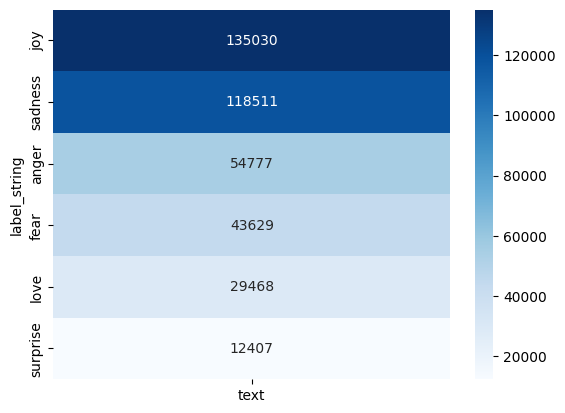

In [19]:
temp = data.groupby('label_string').count()['text'].reset_index().sort_values(by='text',ascending=False)

temp = temp.set_index('label_string')

sns.heatmap(temp, annot=True, fmt='g', cmap="Blues")

<Axes: xlabel='label', ylabel='count'>

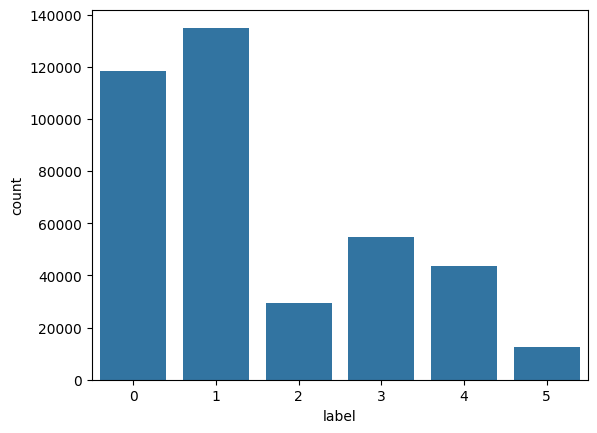

In [20]:
sns.countplot(x='label',data=data)

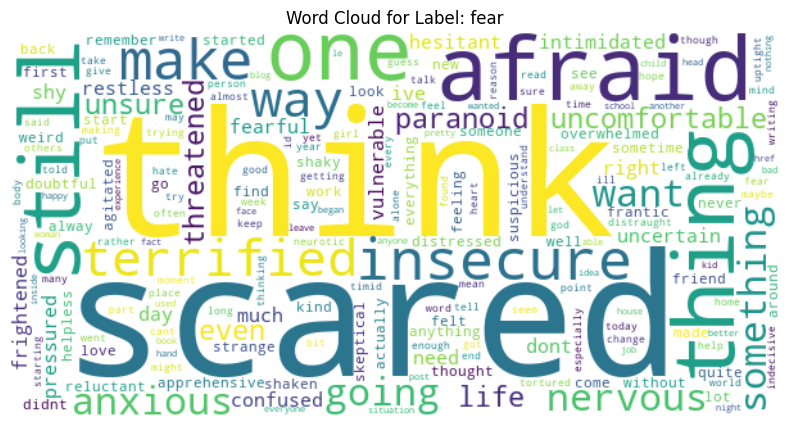

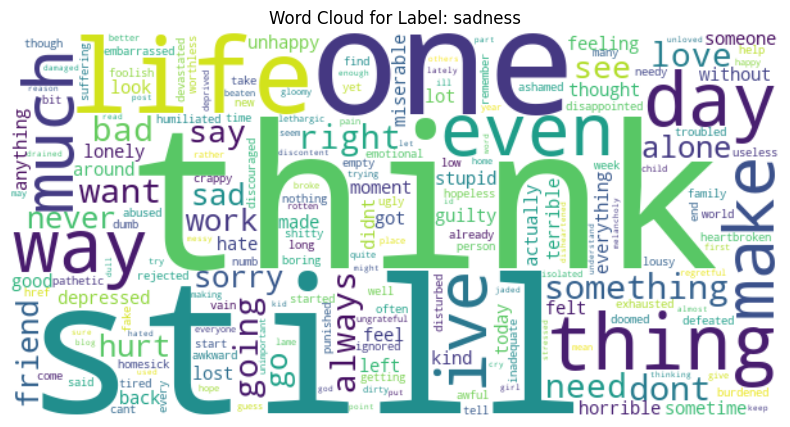

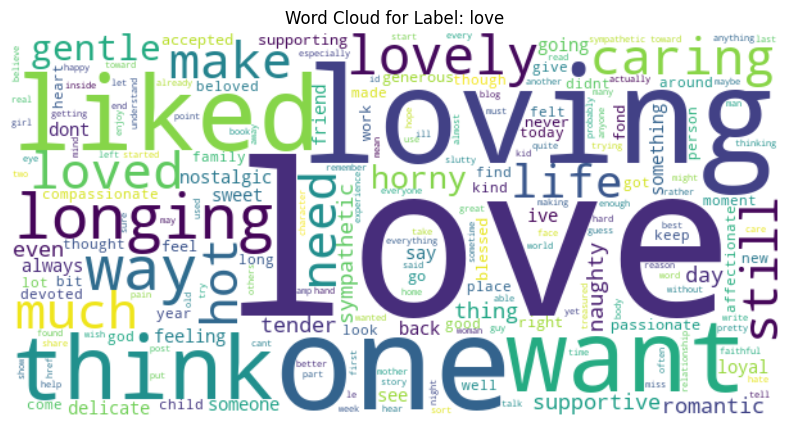

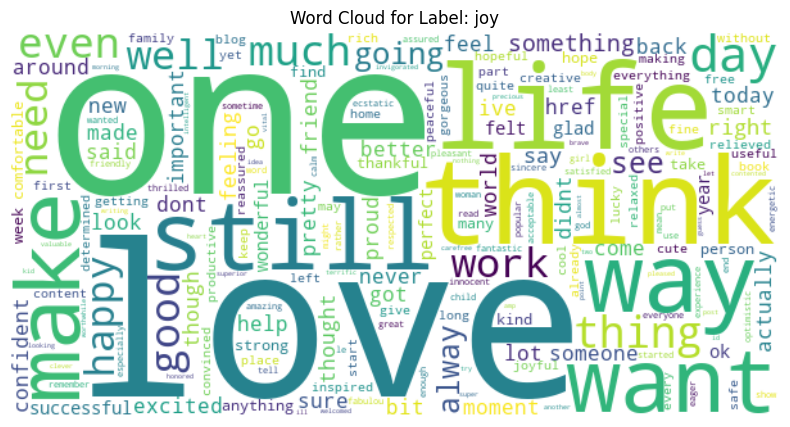

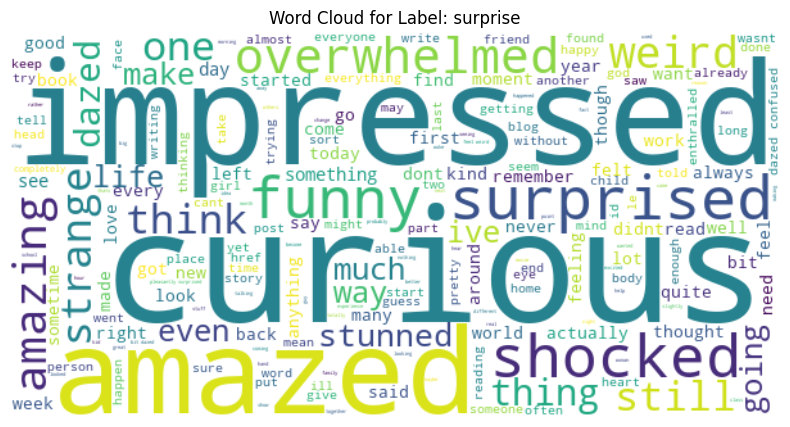

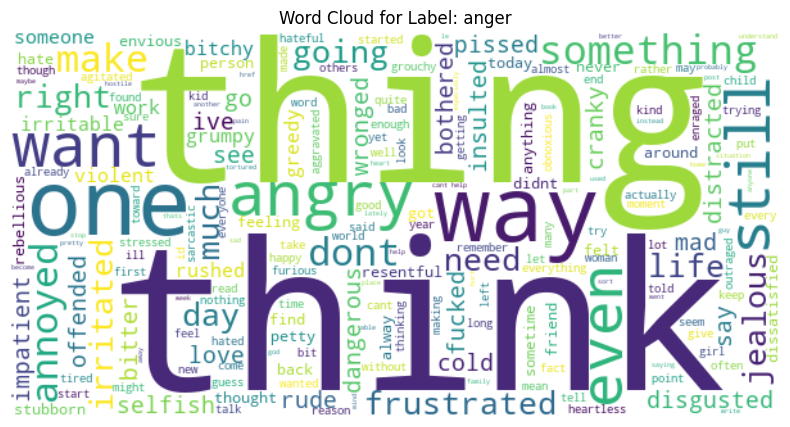

In [21]:
#word cloud
for label in data['label_string'].unique():
    filtered_df=data[data['label_string']==label]
    text=' '.join(filtered_df['text'])
    
    wordcloud=WordCloud(width=600,height=300,background_color='white').generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {label}')
    plt.axis('off')
    plt.show()

C:\Users\sheng\AppData\Local\Temp\ipykernel_36032\953018580.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)


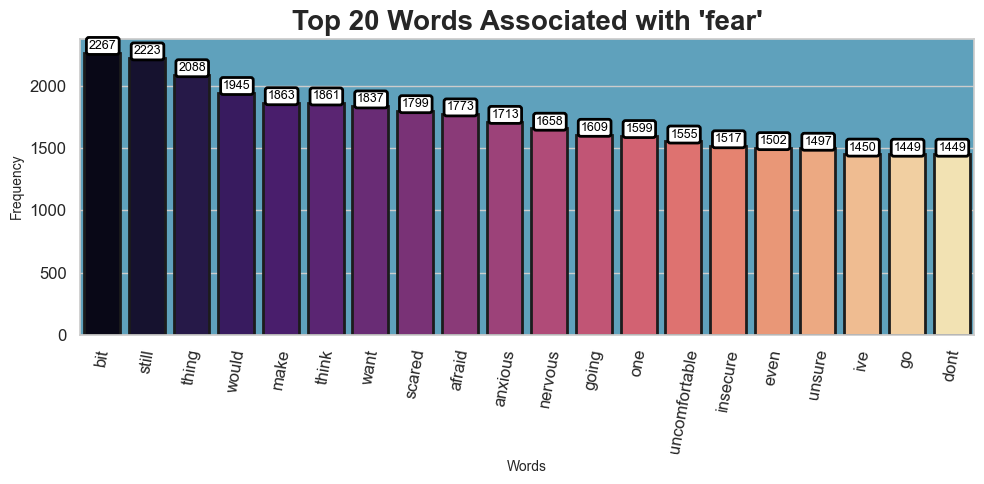

C:\Users\sheng\AppData\Local\Temp\ipykernel_36032\953018580.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)


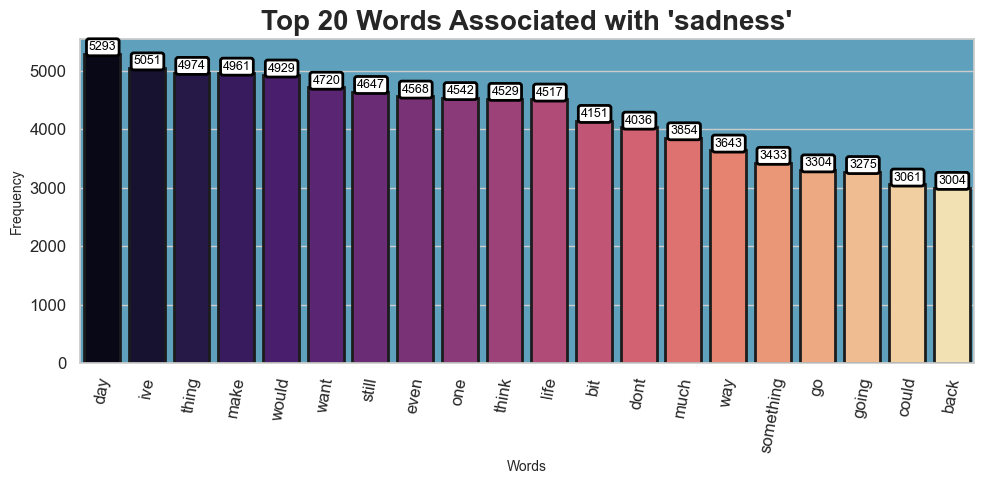

C:\Users\sheng\AppData\Local\Temp\ipykernel_36032\953018580.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)


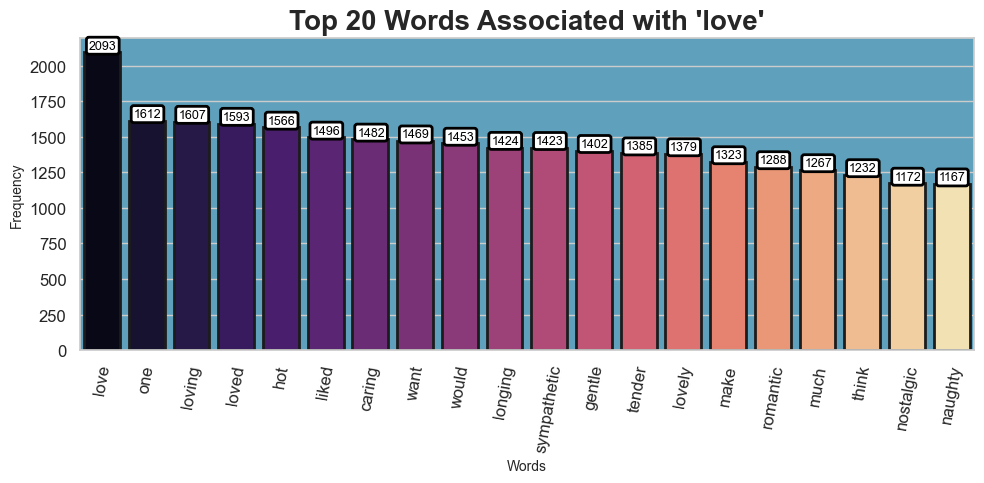

C:\Users\sheng\AppData\Local\Temp\ipykernel_36032\953018580.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)


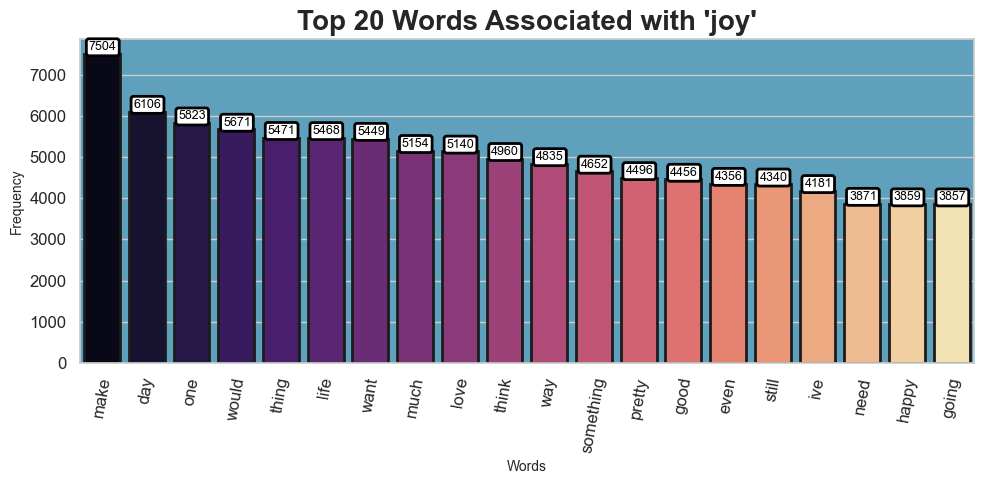

C:\Users\sheng\AppData\Local\Temp\ipykernel_36032\953018580.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)


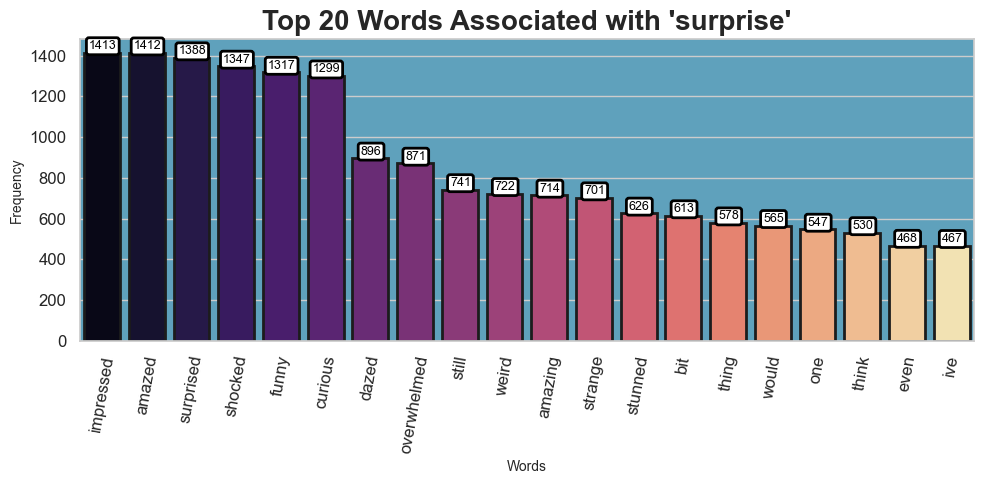

C:\Users\sheng\AppData\Local\Temp\ipykernel_36032\953018580.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)


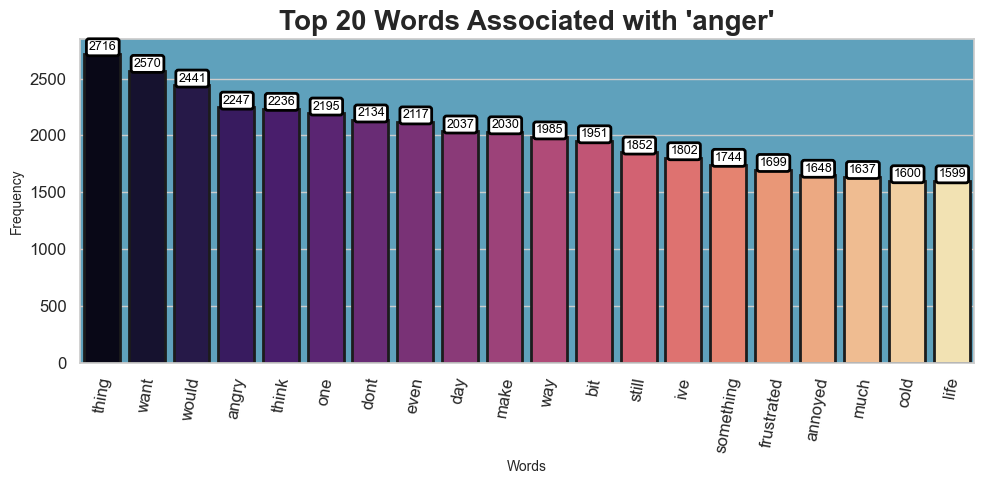

In [22]:
for label in data['label_string'].unique():
    text = data[data['label_string'] == label]['text']

# Tokenize the text and count the frequency of each word
    words = [word.lower() for text in text for word in word_tokenize(text)]
    word_freq = Counter(words)

    # Get the top 20 words
    top_20_words = dict(word_freq.most_common(20))

    # Set the background color and theme
    background_color = '#5fa1bc'
    sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

    # Create a bar plot
    plt.figure(figsize=(10, 5))
    p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
    for container in p.containers:
        plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                      bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
    plt.title(f"Top 20 Words Associated with '{label}'", fontsize=20, fontweight='bold')
    plt.xlabel("Words", fontsize=10 )
    plt.ylabel("Frequency", fontsize=10)
    plt.xticks(rotation=80, fontsize=12,)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

## Model Training and Evaluation

In [23]:
# Store evaluation metrics for all models
eval_dict = {}

We will utilize the __F1 score__ instead of accuracy to assess the effectiveness and performance of our model. 
This is due to the reason there are many more neutral tweets than those positive or negative ones. Accuracy can be misleading in such cases. 
A model might simply predict 'neutral' for every tweet and achieve high accuracy, but it wouldn't be useful for sentiment analysis.

## K-Nearest Neighbor Classifier (KNN)
The k-nearest neighbors (KNN) algorithm is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point. It is one of the popular and simplest classification and regression classifiers used in machine learning today.

KNN takes in data points, and uniquely categorizes them into clusters. When using KNN we first feed into it known data, to train and classify the algorithm. Afterwards we will be able to feed in a new tweet to test, KNN places this new tweet on a graph, and sees which other data points on the plot it is most closely associated with.

Count_Vectorizer transforms the text data of tweets into numerical data such that the KNN Classifer can plot the data on a graph.

In [24]:
count_vectorizer = CountVectorizer(min_df=4)
X = count_vectorizer.fit_transform(data['text'])

y = data['label']

In [25]:
features = count_vectorizer.get_feature_names_out()
len(features)

21666

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

In [27]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [28]:
knn.score(X_test,y_test)

0.8396441049809051

In [29]:
pred=knn.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86     29566
           1       0.83      0.90      0.86     33778
           2       0.84      0.69      0.76      7385
           3       0.88      0.78      0.83     13694
           4       0.86      0.74      0.80     10932
           5       0.83      0.66      0.74      3101

    accuracy                           0.84     98456
   macro avg       0.84      0.78      0.81     98456
weighted avg       0.84      0.84      0.84     98456



Text(92.25, 0.5, 'Actual')

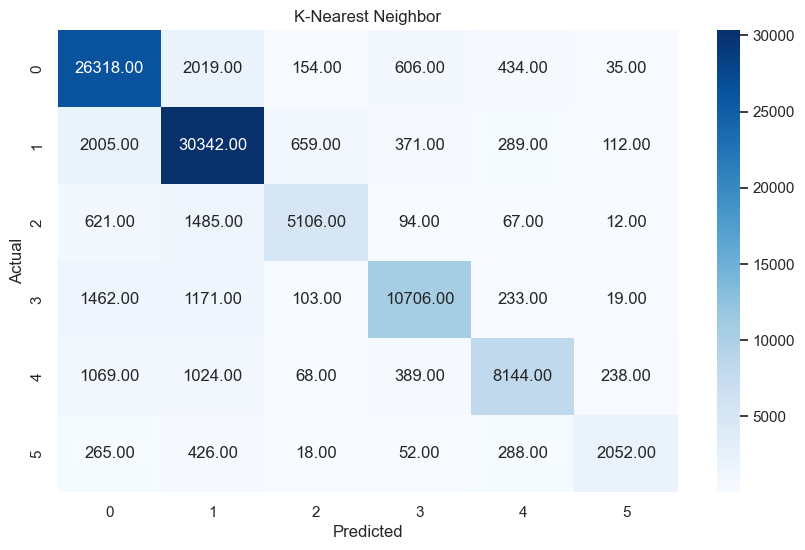

In [30]:
plt.figure(figsize = (10, 6))
cf = confusion_matrix(y_test, pred)
sns.heatmap(cf, annot=True, fmt=".2f", cmap = 'Blues')
plt.title("K-Nearest Neighbor")
plt.xlabel("Predicted")
plt.ylabel("Actual")

## The K value
The k value in the KNN algorithm defines how many neighbors will be checked to determine the classification of a specific query point. For example, if k=1, the instance will be assigned to the same class as its single nearest neighbor. Lower values of k can have high variance, but low bias, and larger values of k may lead to high bias and lower variance.

Here we train and test the KNN Classifier with k values from 1 to 40, to see which k value will be the best suited for our model.

In [31]:
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error rate')

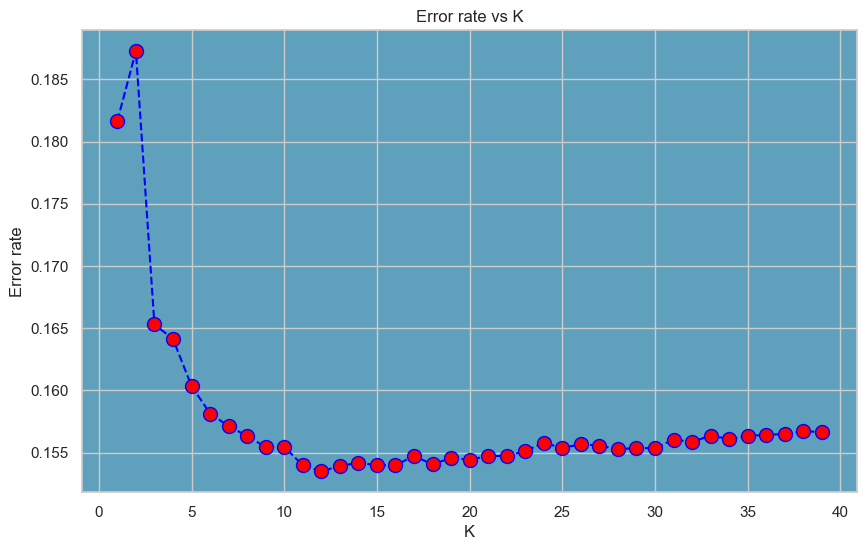

In [32]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue',linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error rate vs K')
plt.xlabel('K')
plt.ylabel('Error rate')

Hence from this graph, we can tell that the most suitable for K-value for KNN model according to our dataset is between 10 to 15 as it has the lowest error rate

In [33]:
eval_dict['K-Nearest Neighbor'] = f1_score(y_test, pred, average = 'weighted')

## Naive Bayes Classifier

Naive Bayes model is a widely used algorithm in machine learning for classification tasks. It leverages Bayes' theorem, a powerful tool in probability, to predict the likelihood of an instance belonging to a particular class. 

Naive Bayes shines when dealing with text data classification, which is exactly where the X's tweet data comes in. Naive Bayes performs well on large datasets. It can efficiently handle the massive amounts of text data. 

> Represent tweet as a collection of features where these features are individual words, presence or absence of specific words. 
> In the sentiment analysis for the data we have, the classes are the 6 classes that we had mentioned above. 
> Naive Bayes assumes independence between words in a tweet given the class. 
> For a new tweet, this model calculates the probability of each word appearing in each class. Using Bayes' theorem, it predicts the class with the highest probability based on the tweet's features.

We use __MultinomialNB__ function from Scikit-learn library. 
> __MultinomialNB__ implements the Naive Bayes algorithm specifically designed for text data. This makes it easy to integrate Naive Bayes algorithm into our text classification workflow.

As we can tell Naive Bayes model did better than KNN model as it achive F1 score of __0.86__

In [34]:
X = data['text']
y = data['label']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [36]:
tf_idf = TfidfVectorizer(max_features=8000)
X_train = pd.DataFrame(tf_idf.fit_transform(X_train).toarray())
X_test = pd.DataFrame(tf_idf.transform(X_test).toarray())
X_train.columns = tf_idf.get_feature_names_out()
X_test.columns = tf_idf.get_feature_names_out()

In [37]:
naive = MultinomialNB()
naive.fit(X_train, y_train)

MultinomialNB()

In [38]:
naive_pred = naive.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, naive_pred)}")

Accuracy Score: 0.8611562525392054


In [39]:
print(classification_report(y_test, naive_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     29628
           1       0.81      0.97      0.88     33758
           2       0.96      0.52      0.67      7367
           3       0.95      0.80      0.87     13694
           4       0.93      0.73      0.82     10907
           5       0.98      0.31      0.47      3102

    accuracy                           0.86     98456
   macro avg       0.91      0.71      0.77     98456
weighted avg       0.87      0.86      0.85     98456



Text(92.25, 0.5, 'Actual')

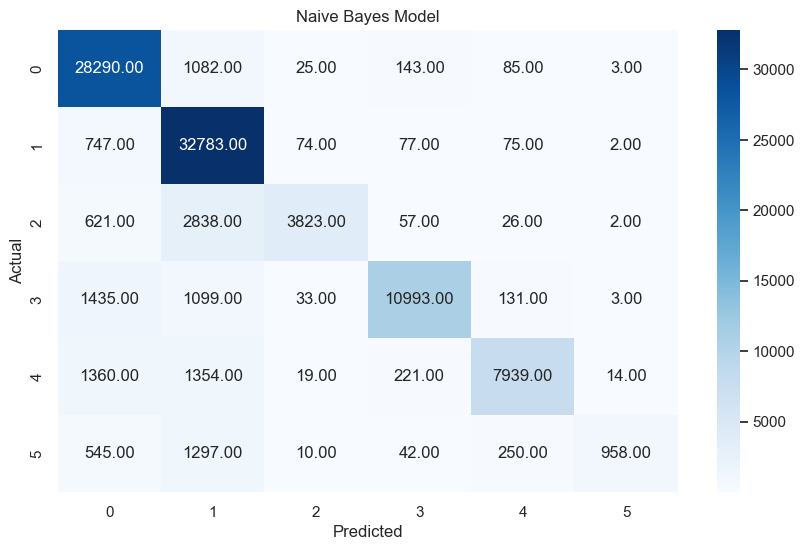

In [40]:
plt.figure(figsize = (10, 6))
cf = confusion_matrix(y_test, naive_pred)
sns.heatmap(cf, annot=True, fmt=".2f", cmap = 'Blues')
plt.title("Naive Bayes Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [41]:
eval_dict['Naive Bayes Model'] = f1_score(y_test, naive_pred, average = 'weighted')

## Conclusion

- In conclusion, the __Naive Bayes model__ is a better model than the __K-nearest Neighbor__ when analyzing sentiment in our X's tweet dataset. Even though their F1 scores are almost the same, where Naive Bayes achieved an F1 score of 0.85 and KNN achieved an F1 score of 0.84. 
- However, the Naive Bayes model exhibited a significant advantage in training time, making it computationally faster for processing large volumes of tweets. 
- These findings suggest that Naive Bayes is a more favorable option for sentiment analysis on X's tweet dataset, which has a large dataset, due to its efficiency and effectiveness.

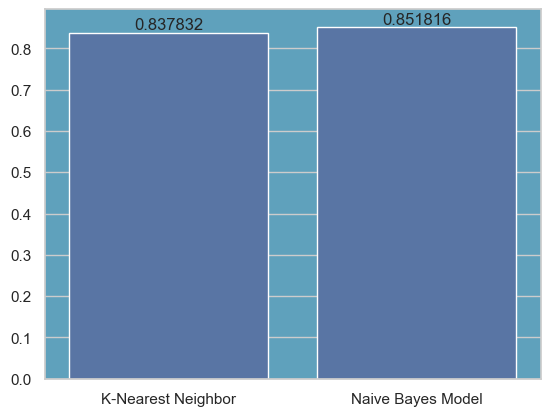

In [42]:
model_name = list(eval_dict.keys())
model_f1 = list(eval_dict.values())

a = sns.barplot(x = model_name, y = model_f1)
for i in a.containers:
    a.bar_label(i)